## Imports

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt

import random
from pathlib import Path
from PIL import Image

from tqdm.notebook import tqdm, trange

## Settings

In [2]:
VARIANT = "A" # Вариант - модели (для разделения моделей с разными гиперпараметрами) result/VARIANT+SEED/
SEED = 451 # Для получения предсказуемых результатов

## Global variables

In [3]:
MODEL_NAME = "residual_dcgan"

DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
# DEVICE = torch.device("cpu")
torch.set_default_device(DEVICE)

LATENT_DIM = 100
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE_G = 0.0002
LEARNING_RATE_D = 0.0002
BETA_1 = 0.5
BETA_2 = 0.999
DROPOUT_P = 0.2

# Пути для сохранения
SAVE_DIR = "./result"
DATA_DIR = "./data"

RESULT_DIR = f"{SAVE_DIR}/{MODEL_NAME}/{VARIANT}{SEED}"
GIF_DIR = f"{RESULT_DIR}/gif"

Path(RESULT_DIR).mkdir(parents=True, exist_ok=True)
Path(GIF_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
if str(DEVICE) == 'cuda':
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Utils

In [5]:
def write_log(msg, log=f"{RESULT_DIR}/hist.log"):
    with open(log, "a") as f:
        f.write(msg + "\n")

In [6]:
def save_models():
     """Сохранение моделей"""
     torch.save(generator.state_dict(),
               f"{RESULT_DIR}/generator.pth")
     torch.save(discriminator.state_dict(),
               f"{RESULT_DIR}/discriminator.pth")

In [7]:
def plot_gan_losses(generator_losses, discriminator_losses, model_name="GAN", save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(generator_losses, label='Generator loss', color='red')
    plt.plot(discriminator_losses, label='Discriminator loss', color='blue')
    
    plt.title(f'{model_name} losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()
    plt.grid()

    if save_path:
        plt.savefig(f"{save_path}/losses", bbox_inches='tight')
        print(f"Save path: {save_path}")

    plt.show()

## Info

In [8]:
print(f"device: {DEVICE}")

write_log("="*16)
write_log(f"device: {DEVICE}")
write_log(f"latent_dim: {LATENT_DIM}")
write_log(f"epochs: {EPOCHS}")
write_log(f"learning_rate_G: {LEARNING_RATE_G}")
write_log(f"learning_rate_D: {LEARNING_RATE_D}")
write_log(f"dropout_p: {DROPOUT_P}")
write_log(f"betas: ({BETA_1},{BETA_2})")
write_log(f"seed: {SEED}")
write_log("="*16)

device: cuda


## Dataset

In [9]:
def get_mnist_dataloader(batch_size=None, data_dir='./data'):
    """Загрузка и подготовка датасета MNIST"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root=data_dir,
        train=True, 
        download=True, 
        transform=transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=torch.Generator(device=DEVICE),
        drop_last=True
    )

    return train_loader


In [10]:
dataloader = get_mnist_dataloader(batch_size=BATCH_SIZE, data_dir=DATA_DIR)

## Models

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, ch, dropout_p=0.0):
        super(ResidualBlock, self).__init__()
        self.fblock = nn.Sequential(
            nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ch),
            nn.Dropout2d(dropout_p),
            nn.LeakyReLU(0.2),

            nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ch),
            nn.Dropout2d(dropout_p),
        )

    def forward(self, x):
        out = self.fblock(x)
        return out + x

n = 32
class BasicGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(BasicGenerator, self).__init__()
        self.model = nn.Sequential(
            
            nn.ConvTranspose2d(latent_dim, n*4, kernel_size=7, stride=1, padding=0, bias=False),
            nn.ReLU(),
            
            nn.ConvTranspose2d(n*4, n*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n*2),
            nn.ReLU(),

            ResidualBlock(n*2),
            nn.ReLU(),

            nn.ConvTranspose2d(n*2, n, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n),
            nn.ReLU(),

            ResidualBlock(n),
            nn.ReLU(),

            nn.ConvTranspose2d(n, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

class BasicDiscriminator(nn.Module):
    def __init__(self):
        super(BasicDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, n, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n, n*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n*2),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),
            
            ResidualBlock(n*2, dropout_p=DROPOUT_P),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(n*2, n*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n*4),
            nn.Dropout2d(DROPOUT_P),
            nn.LeakyReLU(0.2),

            ResidualBlock(n*4, dropout_p=DROPOUT_P),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(n*4, 1, kernel_size=7, stride=1, padding=0),
        )
    
    def forward(self, x):
        return self.model(x)

In [12]:
generator = BasicGenerator(latent_dim=LATENT_DIM)
sm_g = summary(generator, input_size=(1, LATENT_DIM, 1, 1), device=DEVICE)
sm_g

Layer (type:depth-idx)                   Output Shape              Param #
BasicGenerator                           [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-1              [1, 128, 7, 7]            627,200
│    └─ReLU: 2-2                         [1, 128, 7, 7]            --
│    └─ConvTranspose2d: 2-3              [1, 64, 14, 14]           131,072
│    └─BatchNorm2d: 2-4                  [1, 64, 14, 14]           128
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─ResidualBlock: 2-6                [1, 64, 14, 14]           --
│    │    └─Sequential: 3-1              [1, 64, 14, 14]           73,984
│    └─ReLU: 2-7                         [1, 64, 14, 14]           --
│    └─ConvTranspose2d: 2-8              [1, 32, 28, 28]           32,768
│    └─BatchNorm2d: 2-9                  [1, 32, 28, 28]           64
│    └─ReLU: 2-10                        [1, 32, 28, 28]          

In [13]:
discriminator = BasicDiscriminator()
sm_d = summary(discriminator, input_size=(1, 1, 28, 28), device=DEVICE)
sm_d

Layer (type:depth-idx)                   Output Shape              Param #
BasicDiscriminator                       [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           288
│    └─Dropout2d: 2-2                    [1, 32, 28, 28]           --
│    └─LeakyReLU: 2-3                    [1, 32, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           32,768
│    └─BatchNorm2d: 2-5                  [1, 64, 14, 14]           128
│    └─Dropout2d: 2-6                    [1, 64, 14, 14]           --
│    └─LeakyReLU: 2-7                    [1, 64, 14, 14]           --
│    └─ResidualBlock: 2-8                [1, 64, 14, 14]           --
│    │    └─Sequential: 3-1              [1, 64, 14, 14]           73,984
│    └─LeakyReLU: 2-9                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-10                      [1, 128, 7, 7]            131,072


In [14]:
write_log(str(sm_g))
write_log(str(sm_d))

In [15]:
#Optimizers
g_optimizer = optim.Adam(
    generator.parameters(),
    lr=LEARNING_RATE_G,
    betas=(BETA_1, BETA_2)
)

d_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=LEARNING_RATE_D,
    betas=(BETA_1, BETA_2)
)

## Training step

In [16]:
criterion = nn.BCEWithLogitsLoss()


In [17]:
def d_step(real_images, batch_size):
    noise = torch.randn(batch_size, LATENT_DIM, 1, 1)

    fake_label = torch.zeros(batch_size, 1, 1, 1)
    real_label = torch.full((batch_size, 1, 1, 1), 0.9).float()

    with torch.no_grad():
        fake_images = generator(noise)

    discriminator.train()
    d_optimizer.zero_grad()

    fake_pred = discriminator(fake_images.detach())
    d_loss_fake = criterion(fake_pred, fake_label)
    
    real_pred = discriminator(real_images)
    d_loss_real = criterion(real_pred, real_label) 
   
    d_loss =  d_loss_fake + d_loss_real 
    
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()

def g_step(batch_size):
    noise = torch.randn(batch_size, LATENT_DIM, 1, 1)
    
    real_label = torch.ones(batch_size, 1, 1, 1)

    generator.train()
    g_optimizer.zero_grad()

    fake_images = generator(noise)
    fake_pred = discriminator(fake_images)

    g_loss = criterion(fake_pred, real_label)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()     

## Training

In [18]:
history_losses_d = []
history_losses_g = []

#
fixed_noise = torch.randn(64, LATENT_DIM, 1, 1).to(DEVICE)
#

for epoch in trange(EPOCHS, unit="epoch"):
    num_batches = 0
    epoch_d_loss = 0
    epoch_g_loss = 0

    
    tq = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        leave=False,
        unit="batch",)
    
    for i, (real_images, _) in tq :
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)
        epoch_d_loss += d_step(real_images, batch_size)
        epoch_g_loss += g_step(batch_size)
        num_batches += 1

    history_losses_d.append(epoch_d_loss / num_batches)
    history_losses_g.append(epoch_g_loss / (num_batches))
    

    info = f'epoch [{(epoch+1):>3}/{EPOCHS}], ' + \
         f'g_loss: {history_losses_g[-1]:.5f}, ' + \
         f'd_loss: {history_losses_d[-1]:.5f}'

    print(info)

    write_log(info)
    generator.eval() 
    with torch.no_grad():
        gen = generator(fixed_noise)
        save_image(gen.view(gen.size(0), 1, 28, 28),
                  f"{GIF_DIR}/{epoch+1}.png")

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  1/100], g_loss: 1.49438, d_loss: 1.14395


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  2/100], g_loss: 1.19695, d_loss: 1.19649


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  3/100], g_loss: 1.17046, d_loss: 1.20770


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  4/100], g_loss: 1.17449, d_loss: 1.22238


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  5/100], g_loss: 1.10974, d_loss: 1.24474


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  6/100], g_loss: 1.10318, d_loss: 1.25377


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  7/100], g_loss: 1.07341, d_loss: 1.26817


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  8/100], g_loss: 1.06444, d_loss: 1.27078


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [  9/100], g_loss: 1.06706, d_loss: 1.27594


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 10/100], g_loss: 1.08274, d_loss: 1.26485


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 11/100], g_loss: 1.05589, d_loss: 1.27729


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 12/100], g_loss: 1.07078, d_loss: 1.27471


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 13/100], g_loss: 1.05903, d_loss: 1.27409


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 14/100], g_loss: 1.06060, d_loss: 1.27113


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 15/100], g_loss: 1.08341, d_loss: 1.27058


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 16/100], g_loss: 1.06393, d_loss: 1.27165


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 17/100], g_loss: 1.06112, d_loss: 1.27579


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 18/100], g_loss: 1.07634, d_loss: 1.27481


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 19/100], g_loss: 1.07698, d_loss: 1.27552


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 20/100], g_loss: 1.08626, d_loss: 1.27335


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 21/100], g_loss: 1.07088, d_loss: 1.26859


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 22/100], g_loss: 1.07720, d_loss: 1.27149


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 23/100], g_loss: 1.10511, d_loss: 1.26405


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 24/100], g_loss: 1.12067, d_loss: 1.25874


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 25/100], g_loss: 1.12145, d_loss: 1.26082


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 26/100], g_loss: 1.13056, d_loss: 1.25284


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 27/100], g_loss: 1.13043, d_loss: 1.25406


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 28/100], g_loss: 1.12518, d_loss: 1.25210


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 29/100], g_loss: 1.17200, d_loss: 1.24542


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 30/100], g_loss: 1.16738, d_loss: 1.23667


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 31/100], g_loss: 1.16851, d_loss: 1.24052


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 32/100], g_loss: 1.16327, d_loss: 1.23375


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 33/100], g_loss: 1.17868, d_loss: 1.23219


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 34/100], g_loss: 1.17660, d_loss: 1.22843


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 35/100], g_loss: 1.20096, d_loss: 1.22652


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 36/100], g_loss: 1.20872, d_loss: 1.21503


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 37/100], g_loss: 1.22420, d_loss: 1.21035


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 38/100], g_loss: 1.21935, d_loss: 1.21284


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 39/100], g_loss: 1.22996, d_loss: 1.21435


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 40/100], g_loss: 1.19614, d_loss: 1.22049


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 41/100], g_loss: 1.22363, d_loss: 1.22343


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 42/100], g_loss: 1.22668, d_loss: 1.21306


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 43/100], g_loss: 1.22440, d_loss: 1.20479


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 44/100], g_loss: 1.22763, d_loss: 1.19745


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 45/100], g_loss: 1.23264, d_loss: 1.19992


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 46/100], g_loss: 1.22938, d_loss: 1.20408


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 47/100], g_loss: 1.22055, d_loss: 1.21093


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 48/100], g_loss: 1.23129, d_loss: 1.19679


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 49/100], g_loss: 1.22293, d_loss: 1.21867


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 50/100], g_loss: 1.21995, d_loss: 1.21161


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 51/100], g_loss: 1.21311, d_loss: 1.19861


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 52/100], g_loss: 1.21100, d_loss: 1.21460


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 53/100], g_loss: 1.20540, d_loss: 1.21294


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 54/100], g_loss: 1.19104, d_loss: 1.22636


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 55/100], g_loss: 1.22297, d_loss: 1.20833


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 56/100], g_loss: 1.21054, d_loss: 1.20527


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 57/100], g_loss: 1.21994, d_loss: 1.21632


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 58/100], g_loss: 1.20434, d_loss: 1.21507


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 59/100], g_loss: 1.18241, d_loss: 1.22041


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 60/100], g_loss: 1.20394, d_loss: 1.21823


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 61/100], g_loss: 1.22254, d_loss: 1.20597


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 62/100], g_loss: 1.19517, d_loss: 1.21559


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 63/100], g_loss: 1.19478, d_loss: 1.21175


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 64/100], g_loss: 1.18637, d_loss: 1.23124


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 65/100], g_loss: 1.19233, d_loss: 1.22296


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 66/100], g_loss: 1.18692, d_loss: 1.20989


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 67/100], g_loss: 1.19642, d_loss: 1.21637


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 68/100], g_loss: 1.19744, d_loss: 1.21573


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 69/100], g_loss: 1.22031, d_loss: 1.21166


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 70/100], g_loss: 1.20622, d_loss: 1.20818


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 71/100], g_loss: 1.19791, d_loss: 1.21586


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 72/100], g_loss: 1.18509, d_loss: 1.21927


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 73/100], g_loss: 1.21054, d_loss: 1.20750


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 74/100], g_loss: 1.21565, d_loss: 1.20826


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 75/100], g_loss: 1.19402, d_loss: 1.23062


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 76/100], g_loss: 1.19800, d_loss: 1.20739


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 77/100], g_loss: 1.22294, d_loss: 1.20855


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 78/100], g_loss: 1.18236, d_loss: 1.21718


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 79/100], g_loss: 1.22261, d_loss: 1.21075


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 80/100], g_loss: 1.18903, d_loss: 1.21390


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 81/100], g_loss: 1.19507, d_loss: 1.21911


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 82/100], g_loss: 1.20869, d_loss: 1.21894


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 83/100], g_loss: 1.18192, d_loss: 1.22051


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 84/100], g_loss: 1.18537, d_loss: 1.22828


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 85/100], g_loss: 1.18196, d_loss: 1.21406


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 86/100], g_loss: 1.18849, d_loss: 1.22272


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 87/100], g_loss: 1.21507, d_loss: 1.21897


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 88/100], g_loss: 1.21118, d_loss: 1.19797


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 89/100], g_loss: 1.22163, d_loss: 1.20510


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 90/100], g_loss: 1.21091, d_loss: 1.21171


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 91/100], g_loss: 1.21356, d_loss: 1.20288


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 92/100], g_loss: 1.20357, d_loss: 1.22519


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 93/100], g_loss: 1.20565, d_loss: 1.21215


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 94/100], g_loss: 1.21850, d_loss: 1.20693


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 95/100], g_loss: 1.21640, d_loss: 1.20795


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 96/100], g_loss: 1.20624, d_loss: 1.20562


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 97/100], g_loss: 1.21546, d_loss: 1.21104


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 98/100], g_loss: 1.21420, d_loss: 1.19995


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [ 99/100], g_loss: 1.22690, d_loss: 1.20064


  0%|          | 0/234 [00:00<?, ?batch/s]

epoch [100/100], g_loss: 1.20463, d_loss: 1.22063


## Save model

In [19]:
save_models()

## History

Save path: ./result/residual_dcgan/A451


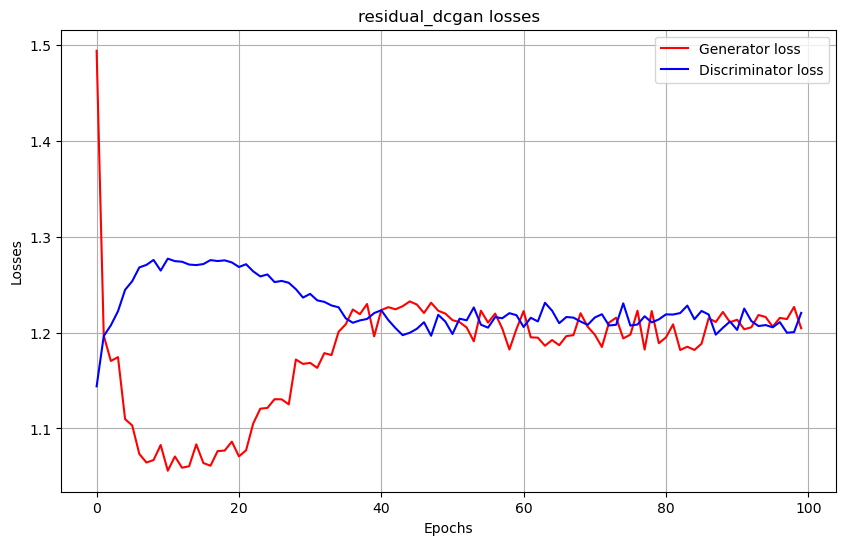

In [20]:
plot_gan_losses(history_losses_g, history_losses_d, MODEL_NAME, RESULT_DIR)